In [93]:
import numpy as np
import h5py
import os
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from methods.base import BaseConfig
# from methods.pore_press_calc_functions import find_pore_pressure

In [26]:
# to pore press calc func 
from pde import PDEBase, PDE, ScalarField, VectorField, MemoryStorage, CartesianGrid
from pde.tools.numba import jit

In [3]:


    # # divergence(xi_field*gradient(P)) = xi_field*laplace(P) + dot(gradient(xi_field), gradient(P)) <----- for more stable numerical scheme
    # if params.eq_non_uniform:
    #     eq = PDE({'P': f"xi_field*laplace(P)  + dot(gradient(xi_field), gradient(P)) + {source_time}*source_field"}, 
    #         bc=bc,
    #         consts={'source_field': source_field, 
    #                 'xi_field': xi_field}
    #         )
    # else:
    #     eq = PDE({'P': f"xi_field*laplace(P) + {source_time}*source_field"}, 
    #         bc=bc,
    #         consts={'source_field': source_field, 
    #                 'xi_field': xi_field}
    #         )  


In [191]:
from scipy import interpolate

class NU_Pore_Press_Diffusion(PDEBase):
    """Diffusion equation with spatial dependence"""
    def __init__(self, perm, params):
        super().__init__()
        self.perm = perm
        self.params = params
        self.shape = self.perm.shape
        self.source_locs = [l['loc'] for l in params.sources]  # list of source locations
        self.source_time_interpolators = [self.make_interp_from_q_list(l['Q']) for l in params.sources] # list of source time funcs

        # generate grid
        x_length, y_length, z_length = params.side_lenght 
        self.grid = CartesianGrid([[0, x_length], [0, y_length], [0, z_length]], self.shape)  

        # boundary condition
        self.bc = 'derivative' # zero derivative at all boundarys

        # diffusion coefficient scalar field
        self.xi_field = self.get_xi_field()

        # initial pore pressure
        self.pore_ini_field = self.get_pore_ini_field()

        # initial zero source field
        self.source_field = self.update_source_field(0) # spatial source field, initial state
    
    def make_interp_from_q_list(self, q_list):
        q = np.array([q_list])
        t = np.linspace(0, self.params.t_range, q.size)
        f = interpolate.interp1d(t, q)
        return f

    def get_xi(self):
        '''
        perm - np.aaray with permeability
        other is taken from params object

    
        Function for calculating the diffusion coefficient. Details - Barenblatt p. 19
        Dimensionality:
        1 MPa = 10^7 g/cm*s^2
        1 mD = 10^-11 cm^2
        1 cP = 10^-2 g/cm*s
        Therefore, the dimensionality of [xi] is:
        [xi] = [mD] * [MPa] / [cP] =
            = 10^-11 [cm^2] * 10^7 [g/cms^2] / 10^-2 [g/cms] =
            = 10^-2 [cm^2/s] =
            = 10^-6 [m^2/s]

        returns numpy array with distributed xi value    
        '''
        xi = 10**-6 * self.perm / (self.params.m0 * self.params.mu * (1/self.params.K_ro + 1/self.params.K_m)) # m^2/s
        return xi * self.params.time_scale # rescaling to time scale
    
    def get_xi_field(self):
        '''
        numpy xi --> scalar field obj xi
        '''
        xi = self.get_xi() # xi
        return ScalarField(self.grid, data=xi)

    def update_source_field(self, t):
        '''
        assembling source points and applying specific rates
        '''
        source_field = ScalarField(self.grid, data=0) # spatial source field
        for ii in range(len(self.source_locs)):
            loc = self.source_locs[ii]
            q = self.source_time_interpolators[ii](t).item()
            dpdt = self.dPdt_Q(q)
            source_field.insert(loc , dpdt)  #  one borehole == point source at params.source_loc location
            
        self.source_field = source_field
        return source_field
          
    
    def dPdt_Q(self, Q):
        '''
        arg  - some float value of Q = dv/dt
        dP/dt ~ K_m * ((dv/dt)/V) - pressure change when dv of fluid is pumped in volume V
        returns float source value, rescaled to time scale
        '''
        V = 2000 * 3.1415 * 0.1**2 / 4  # some "volume" of source (borehole). m^3
        dP = self.params.K_ro * Q / V # pressure change MPa/s
        return dP * self.params.time_scale # rescaling to time scale
    
    def get_pore_ini_field(self):
        '''
        method to ubtain pore pressure initial state. Just for convenience here.
        '''
        p0 = np.ones_like(self.perm) * self.params.P0
        pore_pressure_field = ScalarField(self.grid, data=p0)
        return pore_pressure_field
    
    # def _make_pde_rhs_numba(self, state):
    #     """ 
    #     the numba-acceleratin
    #     it freezes all values when compiling the function, 
    #     so the diffusivity cannot be altered without recompiling.
    #     Have no idea how to use it with time-dependet parameters.
    #     Now it works with initial value of source field 

    #     just uncomment this method to use
    #     """
    #     # make attributes locally available
    #     xi_field = self.xi_field.data
    #     source_field = self.get_source_field(0).data

    #     # create operators
    #     laplace = state.grid.make_operator("laplace", bc=self.bc)
    #     gradient = state.grid.make_operator("gradient", bc=self.bc)
    #     gradient_xi = state.grid.make_operator("gradient", bc="derivative")
    #     dot = VectorField(state.grid).make_dot_operator()

    #     @jit
    #     def pde_rhs(state_data, t=0):
    #         """ compiled helper function evaluating right hand side """
    #         lapace_P = laplace(state_data)
    #         grad_P = gradient(state_data)
    #         grad_xi = gradient_xi(xi_field)
    #         dP_dt = xi_field * lapace_P + dot(grad_xi, grad_P) + source_field
    #         return dP_dt

    #     return pde_rhs


    def evolution_rate(self, state, t=0):
        ''' all magic here '''
        self.update_source_field(t) # very slows down 
        grad_xi = self.xi_field.gradient(bc="derivative")
        lapace_P = state.laplace(bc=self.bc)
        grad_P = state.gradient(bc=self.bc)
        dP_dt = self.xi_field * lapace_P + grad_xi @ grad_P + self.source_field
        return dP_dt
   

In [192]:
perms_path = 'downscaled_models_02_26_2024__16_06_58.h5'

with h5py.File(perms_path, 'r') as f:
    perm = f['perm'][2]

params = BaseConfig(
            sources = [{'loc':(2000, 2000, 2000), 'Q':[1,0,1]},
                       {'loc':(1000, 1000, 2000), 'Q':[-0.1,-0.1,0]}],
            time_scale=86400, 
            t_range=300, 
            dt=0.001)

eq = NU_Pore_Press_Diffusion(perm, params)
p0 = eq.pore_ini_field

storage = MemoryStorage()

In [193]:
res = eq.solve(p0, t_range=params.t_range, dt=params.dt, solver='scipy', tracker=['progress', 'plot', storage.tracker(1)])
pore_press = storage.data

  0%|          | 0/300.0 [00:00<?, ?it/s]

Output()

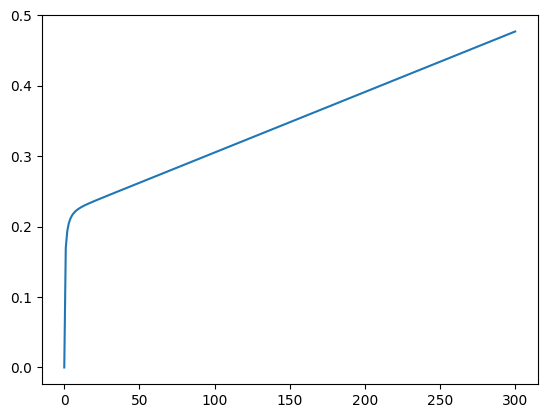

In [190]:
pp = pore_press
ppp = [p[10,10,10] for p in pp]
fig, ax = plt.subplots()
ax.plot(ppp)
# ax.plot(pp[10][:,5,10])
# ax.plot(pp[100][:,5,10])
# ax.plot(pp[180][:,5,10])

https://py-pde.readthedocs.io/en/latest/manual/advanced_usage.html#expressions

https://py-pde.readthedocs.io/en/latest/manual/performance.html#measuring-performance